In [8]:
# Parameters to set to run this notebook

# Initialize helpers.
import numpy as np
import project_path
from model.data_accessor import get_data_file_abs_path
from model.neuron_metadata import *
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
N = neuron_metadata_collection.get_size()

# Constant current injections will be made to these neurons.
I_nA = 0.1
stimulus = {
  "PLMR": I_nA
}

# Neurons to plot membrane potentials for.
neurons_to_observe = NeuronMetadataCollection.create_lr_names_from_base([
  "AIY",
  "ALM",
  "ASE",
  "ASH",
  "ASK",
  "AWA",
  "AWB",
  "AWC",
  "ASK",
  "IL1",
  "IL2",
  "PLM",
  "RIV",
  "RMD"
  ])

# How many timesteps to run simulation for.
simul_time = 2000

# Initial condition
# If you want a fixed-seed initial condition, uncomment the line below.
# np.random.seed(0)
init_conds = 10**(-4)*np.random.normal(0, 0.94, 2*N)

# Run the model

In [9]:
from model.neural_model import NeuralModel
from util.plot_util import *

model = NeuralModel(neuron_metadata_collection)
model.init_conds = init_conds

model.set_I_ext_constant_currents(stimulus)
model.init_kunert_2017()

# Uncomment if you want the default moving-Vth behavior
model.keep_vth_static = True

# Uncomment this if you want to start at a standard equilibrium rather than a random initial condition.
"""
cur_I_ext = np.zeros(N)
neuron_id = neuron_metadata_collection.get_id_from_name("PLMR")
cur_I_ext[neuron_id] = I_nA * 10000
model.cur_I_ext = cur_I_ext
equi = model.compute_standard_equilibrium()
model.init_conds = equi
"""

(v_mat, s_mat, v_normalized_mat) = model.run(simul_time)

# The oscillatory dynamic doesn't stabilize until about dt*300 onwards.
# Also, interactome analysis is done after the first 50 timesteps.
truncated_potentials = v_normalized_mat[300:,:]

Timestep 0 out of 2000
Timestep 100 out of 2000
Timestep 200 out of 2000
Timestep 300 out of 2000
Timestep 400 out of 2000
Timestep 500 out of 2000
Timestep 600 out of 2000
Timestep 700 out of 2000
Timestep 800 out of 2000
Timestep 900 out of 2000
Timestep 1000 out of 2000
Timestep 1100 out of 2000
Timestep 1200 out of 2000
Timestep 1300 out of 2000
Timestep 1400 out of 2000
Timestep 1500 out of 2000
Timestep 1600 out of 2000
Timestep 1700 out of 2000
Timestep 1800 out of 2000
Timestep 1900 out of 2000
Total runtime = 3.51s


# Plot potentials of selected neurons

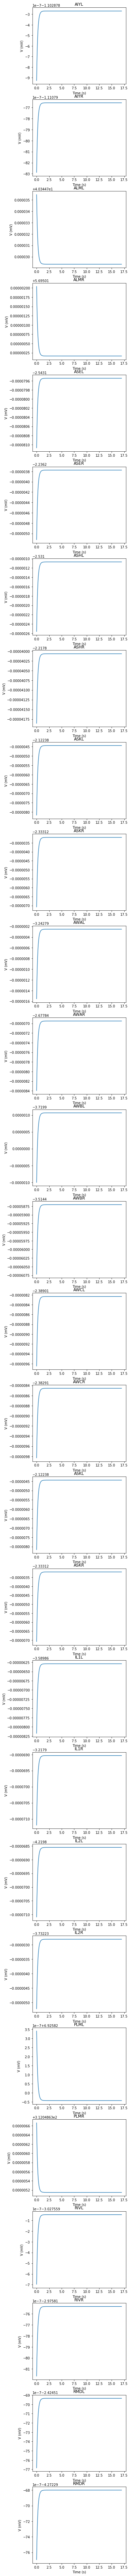

In [10]:
fig, axes = plt.subplots(nrows=len(neurons_to_observe), ncols=1, figsize=(5, 5*len(neurons_to_observe)))
plot_potentials(
  neuron_names_to_show = neurons_to_observe,
  dynamics = v_mat[300:,:],
  is_normalized_v = False,
  dt = model.dt,
  neuron_metadata_collection = neuron_metadata_collection,
  fig_axes = axes)

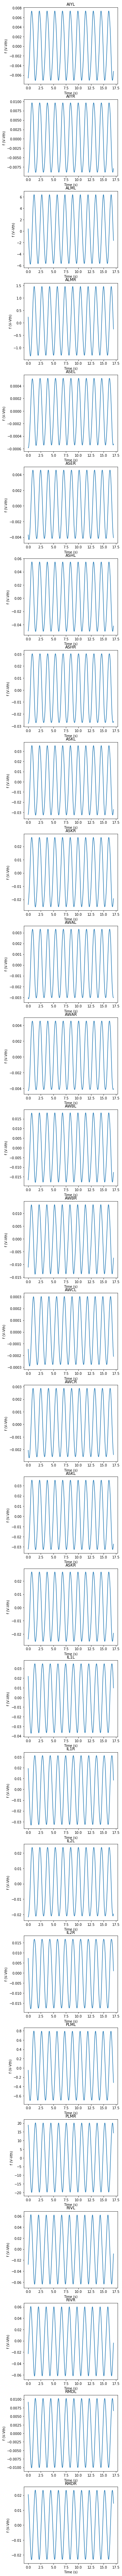

In [4]:
fig, axes = plt.subplots(nrows=len(neurons_to_observe), ncols=1, figsize=(5, 5*len(neurons_to_observe)))
plot_potentials(
  neuron_names_to_show = neurons_to_observe,
  dynamics = truncated_potentials,
  is_normalized_v = True,
  dt = model.dt,
  neuron_metadata_collection = neuron_metadata_collection,
  fig_axes = axes)

# Plot summarized dynamics per neuron class

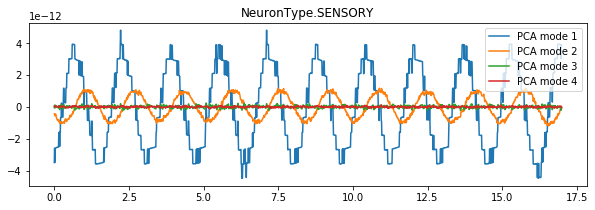

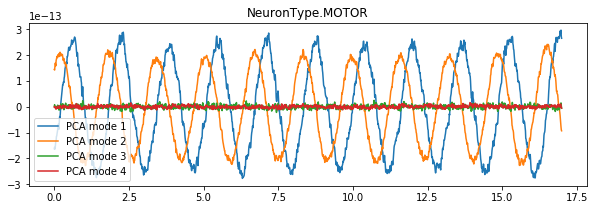

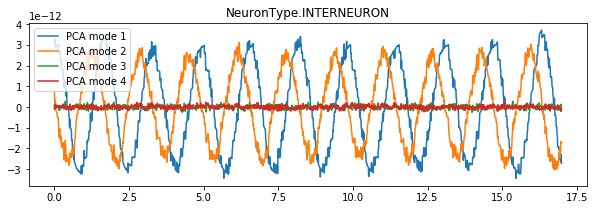

In [15]:
plot_pcas(truncated_potentials, model.dt, neuron_metadata_collection)

In [31]:
equi

array([-3.50000000e+01, -1.83333333e+01, -3.23166339e+00, -4.75308642e+00,
       -2.59610222e+00, -3.50000000e+01, -2.15680545e+00, -1.38585039e+00,
       -3.34988872e+00,  1.33553858e+01, -1.89864743e-01,  9.64797514e+00,
       -3.11400043e+00,  1.04257475e+01, -9.74069878e-01, -1.72543243e+00,
       -1.50457865e+00, -9.39024390e+00, -2.09796672e+00, -6.31147541e+00,
       -3.01144300e+00, -6.31147541e+00, -5.63989454e-01, -1.82196361e+00,
       -2.35434076e+00, -7.62392514e-01,  1.27964145e+01, -8.11950065e-01,
       -6.94617011e-01, -1.13716352e+00, -3.60146301e+00, -8.93937279e-01,
       -1.00605103e+00, -6.31147541e+00, -1.42921899e+00, -2.91620395e+00,
        1.60183728e+01, -2.25273798e+00, -1.45029486e+00, -7.58098301e-01,
       -6.15175497e-01, -1.34630350e+00,  1.65175575e+00, -2.20165115e+00,
        9.11934445e+00, -8.84076202e-01, -2.01370967e+00,  3.53251340e+01,
       -3.40406720e-01, -9.46931000e-02, -1.94962626e+00, -2.13790082e+00,
       -2.44709308e+00,  